# Problem set 3 (43 + 35 = 78 pts)

# Making GANs great (43 pts)

GAN is typical example of high quality generative model. But we are still able to improve it. $G$ is model which maps latent distribution $p_z$ to the output $p_g$. Learning such $G$ that $p_g$ match original data distribution $p_d$ is quite complex task. In general $p_z$ is modeled by normal distribution. The reason for that is simplicity of sampling. But doing this we apply strong limitations on our model. It results in huge number of bad samples (non realistic images). To fix this problem we will correct latent distribution - decrease probability for "bad" samples and increase for "good" ones. Defining the criteria of "good" is not simple in general. So to find solution let's consider derivation for optimal discriminator:

$$D^*(x) = \frac{p_d(x)}{p_d(x) + p_g(x)}$$

Defining $d(x) = \mathrm{logit}(D(x))$ we can rewrite previous expression:

$$p_d(x) = p_g(x)\exp(d(x))$$

Since $p_g(x)$ induced by $p_z$ and $G$:

$$p^*(z) = p_z(z)\exp(d(G(z)))$$

We found the corrected distribution. Similar steps can be applied to non-standard GANs such as Wasserstein GAN (WGAN).

In this task you will be asked to improve the quality by correction of latent distribution for WGAN. An obvious question to ask is: "Why do we take WGAN?". You will answer it by yourself!

## Theoretical part (10 pts)

Suppose we have two 2D distributions: $P_\theta(x,\theta)$ and $P_*(x,\theta^*)$, where $\theta$ some parameter, $\theta^*$ is known fixed value, $x$ is random variable which has uniform distribution $x \sim U(0,1)$. In other words we have two horisontal lines in 2D space with certain $y$ position and $x$ uniformly distributed on the segment [0,1]. Find analytically distance between this distributions in different metrics for all possible values of $\theta$: 

1) KL divergence (2 pts)

2) JS divergence (3 pts)

3) Wasserstein distance (3 pts)

Suppose we would like to optimize parameter $\theta$ in order to fit target distribution $P_*$ with our parametrised distribution $P_\theta$. Which distance will you choose for this task? Why? (2 pts)

In [21]:
%pip install typing-extensions
%pip  install --upgrade torchmetrics
%pip install numpy==1.23.0
%pip install --upgrade typing_extensions
%pip  install --upgrade scikit-image
%pip  install --upgrade typing-extensions
%pip  install --upgrade pandas
%pip  install --upgrade numpy
%pip  install --upgrade scikit-learn
%pip uninstall jax jaxlib
%pip install -U jax jaxlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs000000000000433d00000004'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is

In [16]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.1 MB 3.2 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [22]:
%pip install -q git+https://github.com/kwotsin/mimicry.git torchmetrics torch-fidelity gdown

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-co

In [511]:
#!g1.1
import torch
import torch_mimicry as tmim
import torchvision as tv
import gdown
import tensorflow as tf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2023-05-17 15:44:52.985019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 15:45:00.291144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [512]:
#!g1.1
torch.cuda.is_available()

True

For simplicity we will take architectures for generator and discriminator from open source library torch-mimicry (you are free to change output size of model)

In [409]:
#!g1.1
G = tmim.nets.wgan_gp.wgan_gp_64.WGANGPGenerator64().to(device)
D = tmim.nets.wgan_gp.wgan_gp_64.WGANGPDiscriminator64().to(device)



## Your work starts here

### The first task is to implement loss functions for WGAN-GP (8 pts)

1) Implement loss function for discriminator (1 pts)

2) Implement loss function for generator (1 pts)

3) Implement gradient penalty for discriminator optimization (6 pts)

In [513]:
#!g1.1
def loss_D(d_fake,d_real,D):
    loss_D = D.compute_gan_loss(output_real=d_real,
                                     output_fake=d_fake)
    return loss_D

In [514]:
#!g1.1
def loss_G(output_fake,G):
    # define the loss of generator based on output_fake = D(G(z))
    return G.compute_gan_loss(output=output_fake)

The most important moment in training WGAN-GP is gradient penalty. It is added to discriminator loss to ensure stability. Your goal is to implement following steps:

1) For given $N$ real images $x_{\mathrm{real}}$ and $N$ fake images $x_{\mathrm{fake}}$ compute random interpolation between real and fake samples in following way:

(use .detach() function over $x_{\mathrm{fake}}$ in order to get tensor without gradient graph)

$$x_{\mathrm{interpolation}} = \alpha x_{\mathrm{real}} + (1-\alpha)x_{\mathrm{fake}}$$

where $\alpha \sim U(0,1)$ (sampled from uniform distribution), $x_{\mathrm{real}}$ is of size $[N,3,H,W]$, $x_{\mathrm{fake}}$ is of size $[N,3,H,W]$ and $\alpha$ is of size $[N]$

2) Compute gradient of discriminator output with respect to input (interpolated samples)

$$\nabla D(x_{\mathrm{interpolation}})$$

It will be of size $[N,3,H,W]$, for ease of use reshape it to $[N,3HW]$

3) Compute loss:

$$\mathcal{L} = \mathrm{E}(\|\nabla D(x_{\mathrm{interpolation}})\|_2 - 1)^2$$

Second norm $\|\cdot\|_2$ is taken over second dimension (after reshaping in previous step), mean $\mathrm{E}$ is taken over first dimension. 

In [515]:
#!g1.1
def loss_GP(x_fake,x_real,D):
    # compute gradient penalty
    alpha = torch.rand(x_real.size(0), 1, 1, 1).to(x_real.device)
    x_interpolation = alpha * x_real + (1 - alpha) * x_fake.detach()
    x_interpolation.requires_grad = True
    d_interpolation = D(x_interpolation)

    gradients = torch.autograd.grad(outputs=d_interpolation, inputs=x_interpolation,
                                    grad_outputs=torch.ones_like(d_interpolation),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

### The second task is to implement standard stuff: (6 pts)

1) Download Celeba dataset, apply appropriate data transformation, create dataloader (3 pts)

You can use batch size equal 64. Do not forget to use materials shared on seminars!

2) Initialize optimizers for discriminator and generator (3 pts)

You can take Adam optimizer with **lr** $= 2\cdot 10^{-4}$, $\beta_1$ = 0 and $\beta_2$ = 0.9

In [516]:
from zipfile import ZipFile
from tqdm import tqdm

In [517]:
path = './img_align_celeba.zip'
directory = './'
# Open your .zip file
with ZipFile(file=path) as zip_file:

    # Loop over each file
    for file in tqdm(iterable=zip_file.namelist(), total=len(zip_file.namelist())):

        # Extract each file to another directory
        # If you want to extract to current working directory, don't specify path
        zip_file.extract(member=file, path=directory)

100%|██████████| 202600/202600 [05:26<00:00, 621.15it/s]


In [518]:
#!g1.1
import torch.optim as optim
import torch
import os
import torchvision
from torchvision import transforms
import gdown
from PIL import Image
import numpy as np
import torch_mimicry as tm
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance as FID
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import copy

2023-05-17 15:54:10.758610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 15:54:17.984855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [519]:
#!g1.1
class Dataset(object):
    def __init__(self,data_path,transform=None):
        self.path = data_path
        self.files = os.listdir(data_path)
        self.transform = transform
    def __getitem__(self,idx):
        img = Image.open(os.path.join(self.path,self.files[idx]))
        if self.transform is not None:
            img = self.transform(img)
        return img
    def __len__(self):
        return len(self.files)

In [520]:
#!g1.1
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])
batch_size = 64
dataset = Dataset("./img_align_celeba",transform)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True)

In [521]:
#!g1.1
# your code is here
optimizer_G = torch.optim.Adam(G.parameters(),lr=0.0004,betas=(0.0,0.9))
optimizer_D = torch.optim.Adam(D.parameters(),lr=0.0004,betas=(0.0,0.9))


### The third task is to implement (6 pts)

1) For number of discriminator training iterations **n_dis** optimize total discriminator loss (standard loss + gradient penalty)

$$\mathcal{L}_D = \mathrm{loss}_\mathrm{D}(d_\mathrm{fake},d_\mathrm{real}) + \mathrm{gp}_\mathrm{scale}\mathrm{loss}_{\mathrm{GP}}(x_\mathrm{fake}, x_\mathrm{real},D)$$

You can take $\mathrm{gp}_\mathrm{scale} = 10$, **n_dis** = 2. Use previously implemented functions

2) Optimize generator loss

Use previously implemented functions

3) Repeat steps 1) and 2) for large number of iterations (for example 100k, but you can stop earlier if good result found)

**Upload the weights of trained model to cloud storage (e.g. Google Drive) and add sharing link here**

In [350]:
#!g1.1
def save_models(generator, discriminator, loss_list_G,loss_list_D, epochs):
    torch.save({
                'epoch': epochs,
                'model_state_dict': generator.state_dict(),
                'loss': loss_list_G,
                }, 'save/generator2_model.pt')
    torch.save({
                'epoch': epochs,
                'model_state_dict': discriminator.state_dict(),
                'loss': loss_list_D,
                }, 'save/discriminator2_model.pt')

In [344]:
#!g1.1
def requires_grad(model,flag):
    for param in model.parameters():
        param.requires_grad=flag

In [351]:
#!g1.1
def train(G,D,dataloader,n_dis=2,gp_scale=10,n_iters=10**5):
  # your code is here
    pbar = tqdm(range(n_iters))
    history_loss_D = []
    history_loss_G = []
    for i in pbar:
        #train discriminator for n_dis iterations
        requires_grad(G,False)
        requires_grad(D,True)
        for d_i in range(n_dis):
            x_real = next(iter(dataloader)).to(device)
            x_fake = G(torch.randn(batch_size,128,device=device))
            label_real = D(x_real).ravel()
            label_fake = D(x_fake).ravel()
            
            loss_d = loss_D(label_fake,label_real,D)
            # Add the gradient penalty to the original discriminator loss
            loss_D_total = loss_d + gp_scale * loss_GP(x_fake,x_real,D)
            history_loss_D.append(loss_D_total.item())

            optimizer_D.zero_grad()
            loss_D_total.backward()
            optimizer_D.step()

        #train generator for 1 iteration
        requires_grad(G,True)
        requires_grad(D,False)

        label_fake = D(G(torch.randn(batch_size,128,device=device))).ravel()

        loss_g = loss_G(label_fake,G)
        history_loss_G.append(loss_g.item())

        optimizer_G.zero_grad()
        loss_g.backward()
        optimizer_G.step()
        save_models(G, D,history_loss_G,history_loss_D,i)
        pbar.set_description(f"Loss D {loss_D_total} Loss G {loss_g}")
    return history_loss_D, history_loss_G

In [ ]:
#!g1.1
history_loss_D,history_loss_G = train(G,D,dataloader,n_dis=2,gp_scale=10,n_iters=1500)

Units weren't enought

### Start interrupted training

In [346]:
#!g1.1
state_G = torch.load('./save/generator2_model.pt')
epoch_G = state_G['epoch']
G.load_state_dict(state_G['model_state_dict'])

state_D = torch.load('./save/discriminator2_model.pt')
epoch_D = state_D['epoch']
D.load_state_dict(state_D['model_state_dict'])


<All keys matched successfully>

In [348]:
#!g1.1
G.train()
D.train()

WGANGPDiscriminator64(
  (block1): DBlockOptimized(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (activation): ReLU(inplace=True)
  )
  (block2): DBlock(
    (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU(inplace=True)
    (c_sc): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block3): DBlock(
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU(inplace=True)
    (c_sc): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block4): DBlock(
    (c1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(256, 512, kernel_size=

In [352]:
#!g1.1
history_loss_D,history_loss_G = train(G,D,dataloader,n_dis=2,gp_scale=10,n_iters=1500-epoch_D)

Loss D -0.9691283106803894 Loss G 6.836902141571045: 100%|██████████| 821/821 [33:54<00:00,  2.48s/it]


### The fourth task is to check model performance (3 pts)

1) Evaluate the FID metric for your model (3 pts)

Do not forget to use materials shared on seminars!

In [353]:
#!g1.1
_ = G.eval()

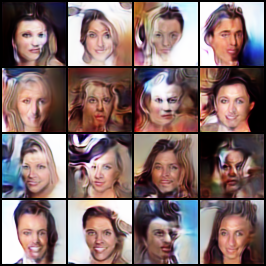

In [354]:
#!g1.1
transforms.ToPILImage()(make_grid(G(torch.randn(16,128,device=device)).detach().cpu(),normalize=True,nrow=4))

Loss values over the last 821 eras

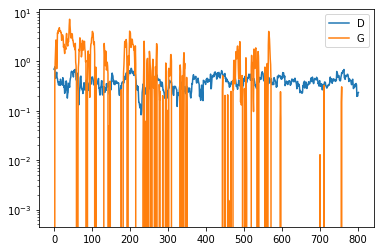

In [356]:
#!g1.1
plt.plot(np.convolve(history_loss_D[::2],np.ones(20),"valid") / 20,label="D")
plt.plot(np.convolve(history_loss_G,np.ones(20),"valid") / 20,label="G")
plt.yscale("log")
plt.legend()

In [412]:
#!g1.1
device = 'cuda'
fid = FID(normalize=True).to(device)
for data in tqdm(dataloader):
    fid.update(data.to(device)/2+0.5,real=True)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /tmp/xdg_cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth

100%|██████████| 3166/3166 [14:23<00:00,  3.67it/s]


In [413]:
#!g1.1
N = 20000
for i in tqdm(range(N//batch_size)):
    fid.update(G(torch.randn(batch_size,128,device=device))/2+0.5,real=False)

100%|██████████| 312/312 [00:57<00:00,  5.42it/s]


In [364]:
#!g1.1
fid = fid.compute().detach().cpu().numpy()
print('FID =', fid)

FID = 62.579185


In [367]:
torch.save(fid, './save/fid.pt')

Links:
Generator weight: https://drive.google.com/file/d/1XrFjhH--DNdYbWiY4UkD5Vc6YitUFrbe/view?usp=share_link

Discriminator weight: https://drive.google.com/file/d/1xEki9jUgvof1FPs22vcbXKPxhcTE2pOR/view?usp=share_link 

FID : https://drive.google.com/file/d/1Vt1VLGoaJ01QZqeRMInuYzFglLf6JG5A/view?usp=share_link

### The last task is to improve performance by correcting latent code sampling procedure (10 pts)

In this part you will implement I-SIR method to sample latent codes from corrected latent distribution and evaluate model performance with updated sampling using FID metric.

#### I-SIR (7 pts)

Algorithm:

* Sample $z \sim N(0,1)$ of shape $[N_s,1,n_z]$, where $n_z$ - size of latent space (128 for our model)

* FOR number of iterations $N_i$:
    * Sample additional particles $z_{\mathrm{add}} \sim N(0,1)$ of shape $[N_s,N_p,n_z]$
    * Concatenate $z$ with $z_{\mathrm{add}}$ along second dimension and reshape to the form $[-1,n_z]$. The result will be new $z$ of size $[N_s(N_p+1),n_z]$
    * Compute logarithm of density for new $z$ 
    
    $\log\rho(z) = -\frac{||z||_2^2}{2} + D(G(z))$ 
    
    and reshape result to the size $[N_s,N_p+1]$.
    * Make element-wise sampling from log density: fix first index and sample second one with respect to corresponding log density value (consider torch.distributions.Categorical). The result will be $idxs$ of size $[N_s]$.
    * Take particles according to sampled indexs $z = z[torch.arange(N_s),idxs]$.
* Return new samples $z$

#### Evaluate model using new sampling procedure (3 pts)

Compute FID metric by sampling latent code using I-SIR function. Leave a comment on obtained results.

In [522]:
#!g1.1
import torch.distributions as dist

def I_SIR(N_i,N_s,N_p,n_z,D,G):
  # your code is here
    z = torch.randn(N_s, 1, n_z).to(device) 
    for _ in range(N_i):
        z_add = torch.randn(N_s, N_p, n_z).to(device)
        z_new = torch.cat([z, z_add], dim=1).reshape(-1, n_z)
        log_density = (-torch.norm(z_new, p=2, dim=1) ** 2 / 2 + D(G(z_new)).squeeze()).reshape(N_s, N_p+1)
        log_probs = torch.log_softmax(log_density, dim=1) 
        idxs = dist.Categorical(logits=log_probs).sample()
        z = z_new.reshape(N_s, N_p+1, n_z)[torch.arange(N_s), idxs].unsqueeze(1)           
    return z.squeeze(1)

In [523]:
#!g1.1
G = tmim.nets.wgan_gp.wgan_gp_64.WGANGPGenerator64().to(device)
D = tmim.nets.wgan_gp.wgan_gp_64.WGANGPDiscriminator64().to(device)

In [524]:
#!g1.1
state_G = torch.load('./save/generator2_model.pt')
G.load_state_dict(state_G['model_state_dict'])
G.eval()

state_D = torch.load('./save/discriminator2_model.pt')
D.load_state_dict(state_D['model_state_dict'])
D.eval()

WGANGPDiscriminator64(
  (block1): DBlockOptimized(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (activation): ReLU(inplace=True)
  )
  (block2): DBlock(
    (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU(inplace=True)
    (c_sc): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block3): DBlock(
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU(inplace=True)
    (c_sc): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block4): DBlock(
    (c1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(256, 512, kernel_size=

In [525]:
#!g1.1
device = 'cuda'
fid = FID(normalize=True).to(device)
for data in tqdm(dataloader):
    fid.update(data.to(device)/2+0.5,real=True)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /tmp/xdg_cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

100%|██████████| 3166/3166 [22:33<00:00,  2.34it/s]  


In [527]:
#!g1.1
N = 20000
batch_size=64
for i in tqdm(range(N//batch_size)): 
    fid.update(G(I_SIR(N_i=1,
                       N_s=batch_size, 
                       N_p=10,
                       n_z=128,
                       D=D,
                       G=G
                       ))/2+0.5, real=False)

100%|██████████| 312/312 [07:22<00:00,  1.42s/it]


In [529]:
#!g1.1
print('FID metric -', fid.compute().detach().cpu().numpy())

FID metric - 63.514668


# Problem 2. Signal processing (35 pts)

In this problem you are supposed to classify Electroencephalography (EEG) signals. You can solve the problem in two ways of your choice - using contrastive learning or using transformer.

## Dataset:

You will work with [EEG Motor Movement/Imagery Dataset (Sept. 9, 2009, midnight)](http://www.physionet.org/physiobank/database/eegmmidb/).
This data set consists of one-minute EEG recordings, obtained from 109 volunteers. 

We will consider Motor Imagenary experiment - a subject imagine opening and closing left or right fist. A target appears on either the left or the right side of the screen. The subject imagines opening and closing the corresponding fist until the target disappears. Then the subject relaxes.

The task is binary classify left and right hand movements from eeg signal.

Data loading \& requirements installation:

In [ ]:
#!g1.1
%pip install -q mne
%pip install -q torcheeg

In [432]:
#!g1.1
import os
import mne
import numpy as np
from torcheeg import transforms
from torcheeg.datasets import MNEDataset

In [ ]:
#!g1.1
metadata_list = [{
    'subject': subject_id,
    'run': run_id
} for subject_id in range(1, 100) # download of experiment data for subjects 1-100 (during debbuging you can take data for fewer subjects)
                 for run_id in [4, 8, 12]]  # Motor imagery experiment: left vs right hand

epochs_list = []
for metadata in metadata_list:
    physionet_path = mne.datasets.eegbci.load_data(metadata['subject'],
                                                   metadata['run'],
                                                   update_path=False)[0]
    raw = mne.io.read_raw_edf(physionet_path, preload=True, stim_channel='auto')
    mne.datasets.eegbci.standardize(raw)

    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)

    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
    events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))
    picks = mne.pick_types(raw.info,
                           meg=False,
                           eeg=True,
                           stim=False,
                           eog=False,
                           exclude='bads')
    epochs_list.append(
        mne.Epochs(raw,
                   events,
                   dict(left=2, right=3),
                   tmin=-1.,
                   tmax=4.0,
                   proj=True,
                   picks=picks))

Let's see what the EEG recording looks like:

In [434]:
#!g1.1
raw

<RawEDF | S099R12.edf, 64 x 19680 (123.0 s), ~9.7 MB, data loaded>

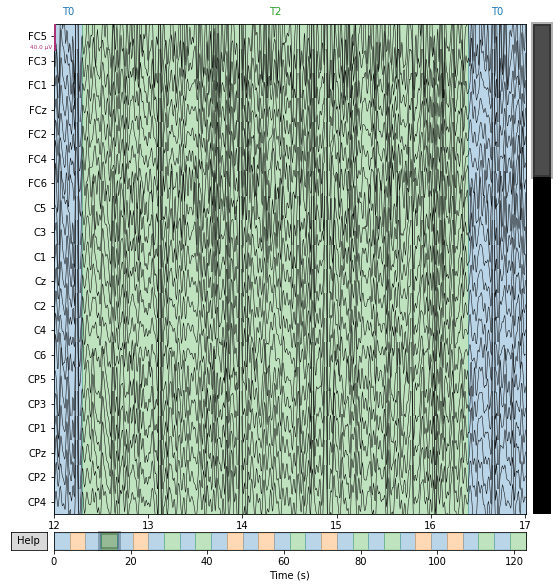

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)
<ipython-input-7-b1bf04b924ce>:2: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw.compute_psd().plot()


Using matplotlib as 2D backend.
Effective window size : 12.800 (s)
Using data from preloaded Raw for 15 events and 801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


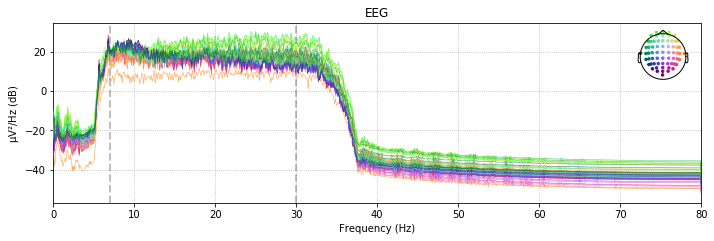

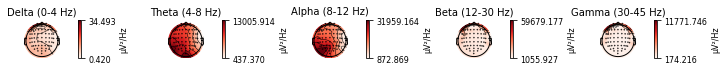

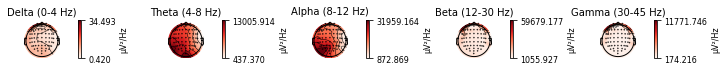

In [435]:
#!g1.1
raw.plot(start = 12, duration = 5)
raw.compute_psd().plot()
epochs_list[-1].compute_psd().plot_topomap()

In [436]:
#!g1.1
print(raw._data)
print("One sample data shape: ", raw._data.shape[0], "chanels x",  raw._data.shape[1], "signal length")

[[ 6.77626358e-21 -1.45717166e-05 -3.93417512e-05 ... -6.99019100e-05
  -5.48512304e-05 -4.60870912e-21]
 [-8.47032947e-21 -7.29407064e-06 -3.23210692e-05 ... -8.63485366e-05
  -6.78305393e-05 -6.32053174e-21]
 [ 6.77626358e-21 -4.74611842e-06 -1.76771611e-05 ... -6.84347096e-05
  -5.66778804e-05 -2.36113434e-21]
 ...
 [ 8.47032947e-21 -9.21410451e-06 -1.16907825e-05 ... -4.39956415e-05
  -3.00844994e-05  1.80969088e-20]
 [ 1.10114283e-20 -9.74920407e-06 -1.25823417e-05 ... -4.40928987e-05
  -2.95876499e-05  2.29880307e-20]
 [ 8.47032947e-22 -1.01831070e-05 -1.24798608e-05 ... -2.99396866e-05
  -2.10006595e-05  9.15248424e-21]]
One sample data shape:  64 chanels x 19680 signal length




Converting data into a usable form [[useful link]](https://torcheeg.readthedocs.io/en/latest/auto_examples/examples_mne_dataset.html):

In [437]:
#!g1.1
dataset = MNEDataset(epochs_list=epochs_list,
                     metadata_list=metadata_list,
                     chunk_size=160,
                     overlap=80,
                     io_path='./tmp_out/dataset/physionet',
                     offline_transform=transforms.Compose(
                         [transforms.MeanStdNormalize(),
                          transforms.To2d()]),
                     online_transform=transforms.ToTensor(),
                     label_transform=transforms.Compose([
                         transforms.Select('event'),
                         transforms.Lambda(lambda x: x - 2)
                     ]),
                     io_mode = 'pickle',
                     num_worker=2)

/kernel/lib/python3.8/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)
[MNE]: 100%|██████████| 297/297 [05:05<00:00,  1.03s/it]

Please wait for the writing process to complete...






**You need to implement ONE of the two approaches!**

## Transformer approach (35 pts)

The Transformer architecture has primarily found fame in processing natural language due to its excellent aptitude for analyzing long-range dependencies - this is beyond the fundamental capabilities delivered by conventional neural networks like CNN and RNN. As EEG classification significantly relies on capturing sequential relationships within the vast array of channels and time points, it has proven to be a difficult task, one that has frequently depended on pre-processing and hands-on feature extraction. However, deep learning with Transformer networks can remove the need for these preliminary steps by leveraging the attention mechanism to extract feature correlations in long-sequential EEG data, which helps visualize the model and appreciate the crucial spatial and temporal relationships in the raw data.

Related articles:
* https://www.nature.com/articles/s41598-022-18502-3
* https://arxiv.org/abs/2202.05170
* https://ieeexplore.ieee.org/document/9391844


In this task you need to implement transformer (you can use ViT transformers, but as a patch you need to use slice - signals splitted along the time dimension) *from scrath* .

**You need to implement ONE of the two approaches!**

In [438]:
#!g1.1
from torcheeg.model_selection import KFold
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score as accuracy
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

In [439]:
#!g1.1
class ViT(nn.Module):
    def __init__(
                    self,
                    img_size= 160,
                    patch_size=16,
                    num_channels=64,
                    num_classes=10,
                    embed_dim=768,
                    depth=12,
                    num_heads=12,
                    mlp_ratio=4,
                    norm_layer=nn.LayerNorm,
                    act_layer=nn.GELU
            ):
        
        super().__init__()
        assert img_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size)
        self.embed_dim = embed_dim
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim) * .02) 
        
        self.blocks = nn.Sequential(*[
            Transformer(embed_dim, num_heads, mlp_ratio, act_layer, norm_layer) for _ in range(depth)
        ])
        self.patch_proj = nn.Linear(num_channels * patch_size, embed_dim)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.head = nn.Linear(embed_dim, num_classes)
        #self.logits = nn.Sigmoid()
        
    def forward(self, x):
        '''
        Args: 
            x: (batch_size, in_channels, img_size[0], img_size[1])
            
        Return:
            (batch_size, num_classes)
        '''
        x = Patches(x, patch_size=self.patch_size)
        x = self.patch_proj(x)
        x = x + self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.blocks(x)
        x = x[:, 0, :]  # take CLS token
        return self.head(x)

In [440]:
#!g1.1
  class MultiHeadAttentionBlock(nn.Module):
    def __init__(self,dim, num_heads=8):
        super().__init__()
        if dim % num_heads:
            raise ValueError('dim % num_heads != 0')
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)
                 
    def forward(self,x):
        #       '''
        # Args: 
        #     x: Tensor of shape (batch_size, seq_len, input_dim)
            
        # Returns:
        #     Tensor of shape (batch_size, seq_len, input_dim)
        # '''
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        # qkv: 3 × B × num_heads × N × head_dim
        q, k, v = qkv.unbind(0)
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        x = attn @ v  # attn: B × num_heads × N × N    v: B × num_heads × N × head_dim
        # B × num_heads × N × head_dim
        x = x.transpose(1, 2).reshape(B, N, C) 
        # B × N × (num_heads × head_dim)
        x = self.proj(x)
        return x

In [441]:
#!g1.1
class Transformer(nn.Module):
      
    def __init__(
            self,
            dim,
            num_heads,
            mlp_ratio=4,  # ratio between hidden_dim and input_dim in MLP
            act_layer=nn.GELU,
            norm_layer=nn.LayerNorm
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = MultiHeadAttentionBlock(dim, num_heads=num_heads)
        self.norm2 = norm_layer(dim)
        self.mlp = nn.Sequential(nn.Linear(dim, dim * mlp_ratio), 
                                 act_layer(), 
                                 nn.Linear(dim * mlp_ratio, dim))

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [442]:
def Patches(signal, patch_size=16):
    return rearrange(signal.squeeze(1), 'batch_size c (s ps) -> batch_size s (c ps)', 
                     ps=patch_size)

* **Data loader, Train loop \& Model trainig** (8pts)

* **Evaluate model**

Provide confusion matrix, F1 score, and loss curve.(3pts)

Report on obtained results.(2pts)


In [450]:
#!g1.1
import torch
from torch.utils.data import DataLoader

In [465]:
#!g1.1
train_dataset, test_dataset = train_test_split(dataset, shuffle=True, test_size=0.2)

train_loader = DataLoader(train_dataset, batch_size=800, num_workers=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=800, num_workers=8, shuffle=False)

In [445]:
#!g1.1
from tqdm import tqdm
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import transforms

In [446]:
#!g1.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(num_classes=2).to(device)

In [505]:
#!g1.1
def train(model, train_loader,optimizer, criterion):

    train_loss = []
    train_acc_history = []

    model.train()
    loss_epoch = 0.0
    train_acc = 0.0   

    for x,y in tqdm(train_loader):
        
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        _, preds = torch.max(y_hat, 1)
        loss = criterion(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
        loss_epoch += loss.item() * x.size(0)
        train_acc += torch.sum(preds == y.data)
        
    train_loss = loss_epoch/len(train_dataset)
    train_acc = train_acc.double()/len(train_dataset)    

    return train_loss, train_acc

def test(model, dataloader, optimizer, criterion):
    
    test_acc_history = []
    test_loss_history = []
    model.eval()
    test_acc = 0.0
    loss_epoch = 0.0

    for x, y in tqdm(test_loader):
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            _, preds = torch.max(y_hat, 1)
            loss = criterion(y_hat, y)
            optimizer.zero_grad()  
            loss_epoch += loss.item() * x.size(0)
            test_acc += torch.sum(preds == y.data)
            
    test_loss = loss_epoch/len(test_dataset)        
    test_acc_epoch = test_acc.double()/len(test_dataset) 

    return test_loss, test_acc_epoch

In [506]:
#!g1.1

N_EPOCHS = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

In [507]:
#!g1.1
train_loss , test_loss = [], []
test_acc_history, train_acc_history = [], []

for epoch in range(N_EPOCHS):

    train_loss_epoch, train_acc_epoch = train(model, train_loader,optimizer, criterion)
    test_loss_epoch, test_acc_epoch = test(model, test_loader, optimizer, criterion)
    train_loss.append(train_loss_epoch)
    test_loss.append(test_loss_epoch)
    test_acc_history.append(test_acc_epoch) 
    train_acc_history.append(test_acc_epoch)
    print(f'Epoch: {epoch+1} || Train Loss: {train_loss_epoch:.4f}, Train Acc: {train_acc_epoch:.4f} || Test Loss: {test_loss_epoch:.4f} Test Acc: {test_acc_epoch:.4f}')
    torch.save({
            'model_state_dict': model.state_dict(),
            'loss': criterion,
            }, './egg_model3.pt')

100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


Epoch: 1 || Train Loss: 0.7596, Train Acc: 0.5295 || Test Loss: 0.6909 Test Acc: 0.5348


100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

Epoch: 2 || Train Loss: 0.6715, Train Acc: 0.5810 || Test Loss: 0.6890 Test Acc: 0.5610



100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

Epoch: 3 || Train Loss: 0.6420, Train Acc: 0.6261 || Test Loss: 0.7035 Test Acc: 0.5792



100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

Epoch: 4 || Train Loss: 0.5736, Train Acc: 0.6955 || Test Loss: 0.7045 Test Acc: 0.5995



100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

Epoch: 5 || Train Loss: 0.4518, Train Acc: 0.7848 || Test Loss: 0.7090 Test Acc: 0.6376



100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


Epoch: 6 || Train Loss: 0.2858, Train Acc: 0.8780 || Test Loss: 0.8528 Test Acc: 0.6585


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

Epoch: 7 || Train Loss: 0.1725, Train Acc: 0.9292 || Test Loss: 0.9729 Test Acc: 0.6651



100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


Epoch: 8 || Train Loss: 0.1162, Train Acc: 0.9558 || Test Loss: 1.0512 Test Acc: 0.6688


100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


Epoch: 9 || Train Loss: 0.0794, Train Acc: 0.9713 || Test Loss: 1.0377 Test Acc: 0.6828


100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


Epoch: 10 || Train Loss: 0.0590, Train Acc: 0.9788 || Test Loss: 1.1869 Test Acc: 0.6798


100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


Epoch: 11 || Train Loss: 0.0509, Train Acc: 0.9817 || Test Loss: 1.2942 Test Acc: 0.6892


100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


Epoch: 12 || Train Loss: 0.0371, Train Acc: 0.9863 || Test Loss: 1.3611 Test Acc: 0.6810


100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

Epoch: 13 || Train Loss: 0.0396, Train Acc: 0.9853 || Test Loss: 1.4560 Test Acc: 0.6899



100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


Epoch: 14 || Train Loss: 0.0342, Train Acc: 0.9872 || Test Loss: 1.3471 Test Acc: 0.6898


100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Epoch: 15 || Train Loss: 0.0316, Train Acc: 0.9893 || Test Loss: 1.4159 Test Acc: 0.6825


100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


Epoch: 16 || Train Loss: 0.0272, Train Acc: 0.9904 || Test Loss: 1.3984 Test Acc: 0.6877


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

Epoch: 17 || Train Loss: 0.0234, Train Acc: 0.9919 || Test Loss: 1.3119 Test Acc: 0.6957



100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


Epoch: 18 || Train Loss: 0.0219, Train Acc: 0.9926 || Test Loss: 1.4012 Test Acc: 0.6968


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

Epoch: 19 || Train Loss: 0.0233, Train Acc: 0.9921 || Test Loss: 1.4269 Test Acc: 0.6904



100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

Epoch: 20 || Train Loss: 0.0257, Train Acc: 0.9905 || Test Loss: 1.3413 Test Acc: 0.6878


At epoch 18, rounding accuracy reaches 69.68% ~ 70%. Next comes the overfitting
link to weights https://drive.google.com/file/d/1_pVKNQcyd1_xLFfmUofVG06kCpeK7zTL/view?usp=share_link

In [508]:
#!g1.1
train_acc_history = [acc.item() for acc in train_acc_history]
test_acc_history = [acc.item() for acc in test_acc_history]

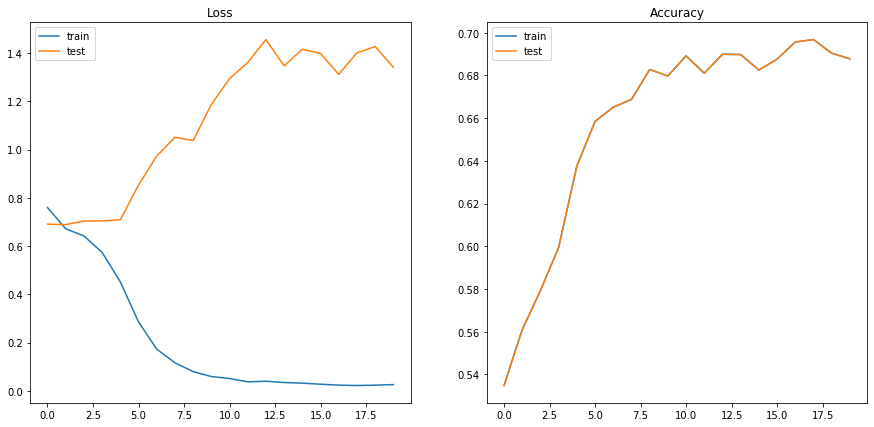

In [509]:
#!g1.1
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2,figsize=(15, 7))

ax[0].plot(range(len(train_loss)), train_loss, label='train')
ax[0].plot(range(len(test_loss)), test_loss, label='test')
ax[0].legend()
ax[0].set_title("Loss")

ax[1].plot(range(len(train_acc_history)), train_acc_history, label='train')
ax[1].plot(range(len(test_acc_history)), test_acc_history, label='test')
ax[1].legend()
ax[1].set_title("Accuracy")
plt.show()

In [510]:
#!g1.1
from sklearn.metrics import f1_score
def print_confussion_matrix_and_f1(dataloader, model, device='cuda'):
    confusion_matrix = torch.zeros(2, 2)
    f1 = 0   
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
            f1 += f1_score(labels.detach().cpu().numpy(), preds.detach().cpu().numpy())
        f1 /= len(dataloader) 

    print()
    print("F1 score:", f1)     
    print("Confusion matrix:")
    print(confusion_matrix)
    
print_confussion_matrix_and_f1(test_loader, model)

100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


F1 score: 0.6747606370178516
Confusion matrix:
tensor([[2906., 1113.],
        [1381., 2588.]])


### Efficient transformers (10 pts)

One of the key issues in a transformer is its quadratic complexity in relation to the length of the input sequence. This quadratic complexity can be computationally expensive, making it harder to scale transformers to longer sequences. Specifically, computing the attention matrix requires an $O(N^2)$ operation per layer, where $N$ is the length of the input sequence. This makes training and inference for large input sequences infeasible due to limitations in the available computational resources. 


Propose 2 implementation of eficient transformers, provide references and main idea of selected approaches. (2 pts)

Implement one of the approaches, compare inference with the previous model, make a conclusion. (8 pts)
